# <span style="color:orange"> Exercise 7 </span>
## <span style="color:green"> Task </span>
The tasks for this exercise are:
<ul>
    <li>7.1: print out instantaneous values of potential energy per particle, $U/N$, and pressure, $P$, along **equilibrated** Monte Carlo simulations.
        <ol>
            <li> Compute and make pictures with a python script of the autocorrelation functions of $U/N$ and $P$ to approximately estimate how large the blocks in your simulations should be.
            <li> Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ and $P$ for different size of the blocks in the data blocking technique
        </ol>
     <li> 7.2: Include the calculation of the radial distribution function, $g(r)$, as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L/2\right]$
     <li> 7.3: Include the calculation of the radial distribution function, $g(r)$, inside the previously used Molecular Dynamics code
     <li> 7.4: equilibrate and perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu), and compare your MC results for the radial distribution function, $g(r)$, with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.
         
         
## <span style="color:green"> Solution </span>
The exercise is made up of a main.cpp file to run the simulation, a NVT.hpp file to host the class for the simulation and multiple input files with the values of the parameters for each state of matter.  The simulation is called from the following Python script, 5 times for each phase. The autocorrelation is then computer, in order to see how much the time series of a variable is dependant on past values. 

In [2]:
try:
    import configparser
    import os,sys
    import subprocess
    import time
    import numpy as np
    import statsmodels.api as sm
    from scipy.optimize import curve_fit
    from functools import wraps
    from statsmodels.graphics.tsaplots import plot_acf
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import pyplot as plt
    from dataclasses import dataclass
    print("Ex7: Imports completed\n")
except Exception as E:
    print("Ex7: Could not import a package")
    print(E)

config_file = "config.ini"
myconf = configparser.ConfigParser()
myconf.read(config_file)

phases = ["solid","liquid","gas"]
variables = ["epot","pres"]
titles = ["Potential Energy","Pressure"]
iters = 5

# fit functions
def exp(x,a,b):
    x = np.asfarray(x)
    return a*np.exp(b*x)
vec_exp = np.vectorize(exp)

def hyperbole(x,a,b):
    x = np.asfarray(x)
    return a+b/x
vec_hyperbole = np.vectorize(hyperbole)

def f(x,a,b):
    x = np.asfarray(x)
    return a+np.exp(-x/b)

##### functionalities

def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

def clean():
    """
    Calls clean script --> Cleans all previous outputs
    """
    p = subprocess.Popen("./clean.sh",shell=True,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    out, err = p.communicate()
    
def measure(func):
    """Measure decorator
    Measures the execution time of a function.
    """
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(time.time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            millis = int(round(time.time() * 1000)) - start
            seconds=(millis/1000)%60
            seconds = int(seconds)
            minutes=(millis/(1000*60))%60
            minutes = int(minutes)
            hours=(millis/(1000*60*60))%24
            print ("%d:%d:%d:%" % (hours, minutes, seconds))
    return _time_it

@dataclass
class Results:
    """Results class -> Stored results of the NVT simulation
    -- Phase(str): Represent the state of the system (solid,liquid,gas)
    -- Variable(str): Represent the variable associated with the results (epot,pres)
    -- instant(array): Array of instantanous values of the variable
    -- ave(dict): Dict containing an array of the averaged values of the variable together with the statistical uncertainty.
    """
    phase : str
    variable : str
    instant : np.array
    ave : dict
        
    def get_phase(self):
        return self.phase
        
    def get_var(self):
        return self.variable
    
    

Ex7: Imports completed



In [41]:
### ---> Main simulation (please do not execute unless needed, execution time is very long)
start = time.time()
clean()
for phase in phases:
    print(f"---> {phase}")
    p = subprocess.Popen("make && ./main inputs/{phase}.ini".format(phase=phase),shell=True,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    out, err = p.communicate()
    #print(out.decode("utf-8"))
    #print(err.decode("utf-8"))
print("\nExec time: ",time.time() - start)

---> solid
---> liquid
---> gas

Exec time:  3789.7347950935364


In [3]:
#save results

results = []
gaves = []
for p in phases:
    for v in variables:
        i, ave, val, err = np.loadtxt("outputs/{phase}/ave_{var}.dat".format(phase=p,var=v),unpack=True)
        instant = np.loadtxt("outputs/{phase}/instant_{var}.dat".format(phase=p,var=v),unpack=True)
        avedict = {
            "value" : val,
            "error" : err
        }
        results.append( Results(phase=p, variable=v, instant=instant, ave = avedict) )

<br> The instantaneous values for potential energy per particle and pressure along equilibrated simulations are graphed below, for all thermodynamic conditions. 

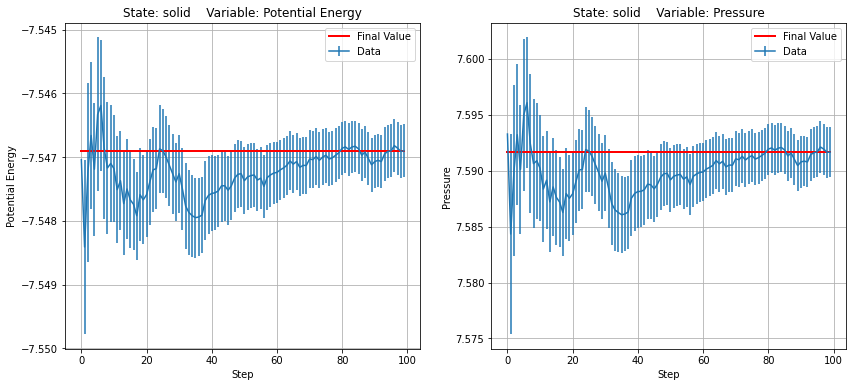

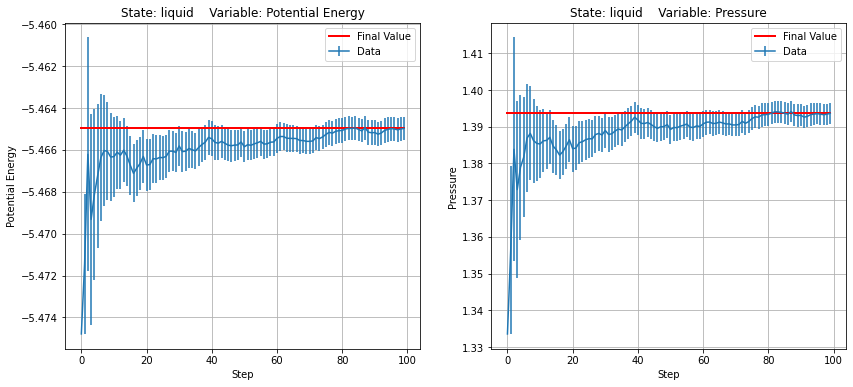

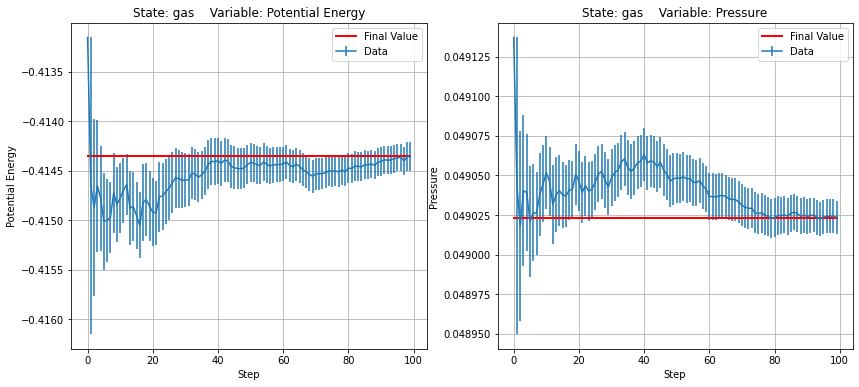

In [4]:
for i1, p in enumerate(phases):
    fig, ax = plt.subplots(1,2, figsize=(14,6))
    for i2, var in enumerate(variables):
        r = next(item for item in results if item.get_phase()==p and item.get_var()==var)
        ax[i2].set_title(f"State: {p}    Variable: {titles[i2]}")
        ax[i2].set_ylabel(titles[i2])
        ax[i2].set_xlabel("Step")
        ax[i2].errorbar([i for i in range(len(r.ave["value"]))], r.ave["value"], yerr=r.ave["error"], label="Data")
        ax[i2].plot([r.ave["value"][-1] for k in range(len(r.ave["value"]))], color="red", linewidth=2, label="Final Value")
        ax[i2].grid(True)
        ax[i2].legend()

### Autocorrelation
Autocorrelation (ACF) is a calculated value used to represent how similar a value within a time series is to a previous value.
A lag is the number of previous observations measured during autocorrelation, which in this case is set to 50.

---> Index1: 0	Phase: solid
---> Index1: 1	Phase: liquid
---> Index1: 2	Phase: gas


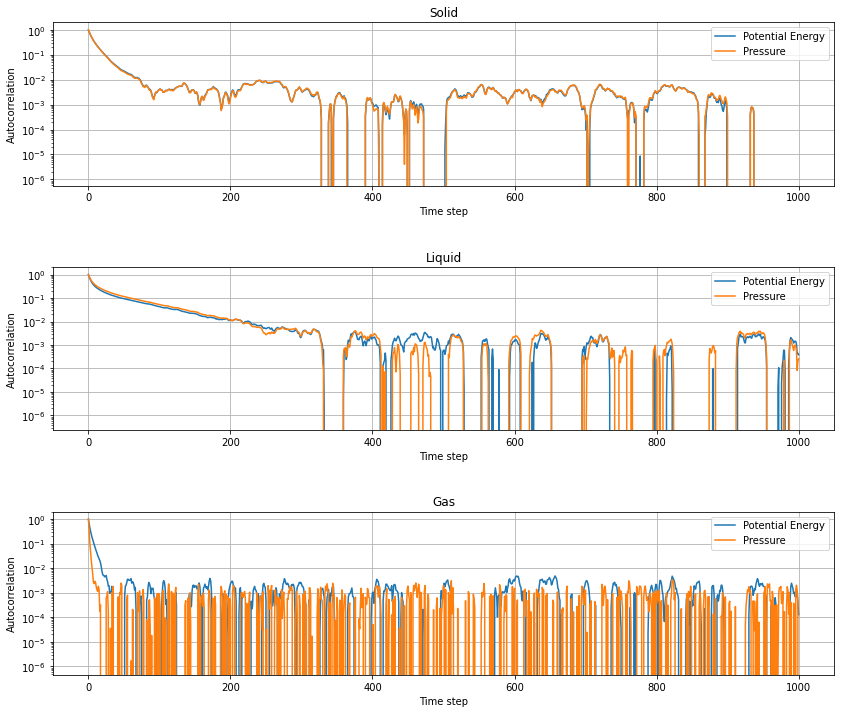

In [6]:
acf_lags = 1000
func = f
fig, ax = plt.subplots(3,1,figsize=(14,12),gridspec_kw={'hspace': 0.5})
for i1, p in enumerate(phases):
    print(f"---> Index1: {i1}\tPhase: {p}")
    for i2, v in enumerate(variables):
        r = next(item for item in results if item.get_phase()==p and item.get_var()==v)
        instant = r.instant
        acf, ci = sm.tsa.acf(instant, alpha=0.05, nlags=acf_lags, fft=True)
        x = [c[0] for c in ci]
        y = [c[1] for c in ci]
        ax[i1].plot(acf, label=titles[i2])
    ax[i1].set_title(f"{r.get_phase().capitalize()}")
    ax[i1].grid(True)
    ax[i1].set_yscale("log")
    #ax[i1].set_xscale("log")
    ax[i1].set_xlabel("Time step")
    ax[i1].set_ylabel("Autocorrelation")
    ax[i1].legend()

It can be observed that when the block number exceeds the optimal block size, the error on the observable halts and begins oscillating. As one would expect, correlation in the gaseous phase drops much faster than in the liquid and solid one. Thanks to the correlation for each state, one can figure out the optimal value for the number of blocks.

### Function $g(r)$
<br> In the following cell, the radial distribution function $g(r)$ is plotted for each phase of the system.

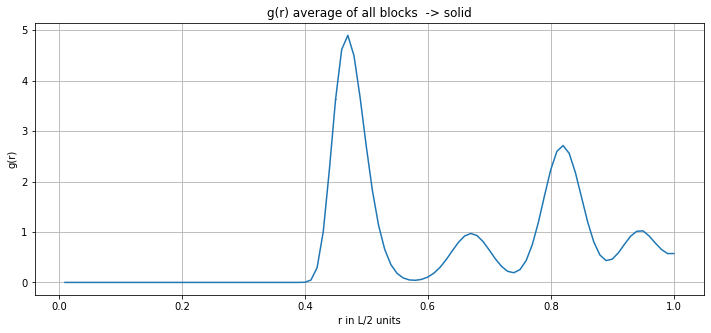

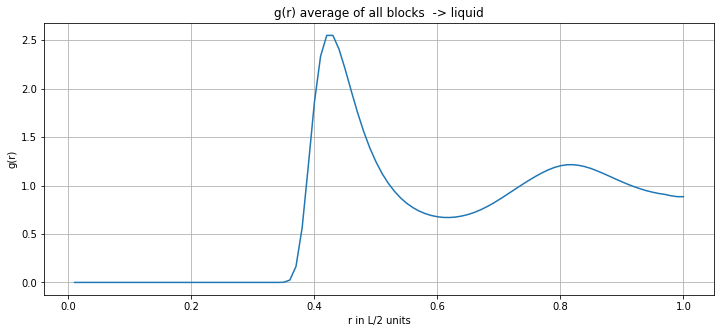

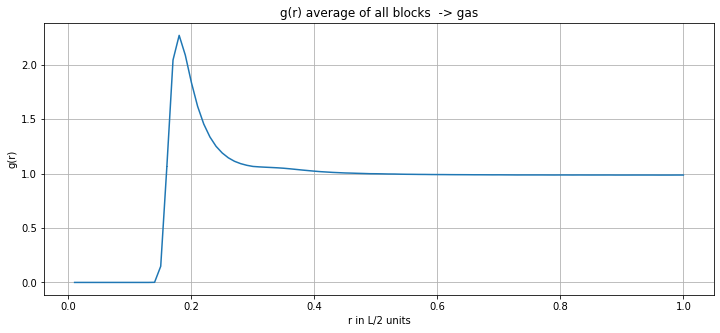

In [17]:
nblk = 100
for p in phases:
    fig, ax = plt.subplots(figsize=(12,5))
    data = np.loadtxt(f"./outputs/{p}/ave_gofr.dat")
    datalist = np.split(data,nblk)
    i, data, error = np.loadtxt(f'./outputs/{p}/ave_gave.dat', usecols=(0,1,2),delimiter='	', unpack='true', skiprows=(nblk-1)*len(datalist[1]))

    plt.errorbar(np.arange(1./len(datalist[1]),1.+1./len(datalist[1]),1./len(datalist[1])),data, yerr=error)
    plt.title(f"g(r) average of all blocks  -> {p}")
    plt.xlabel("r in L/2 units")
    plt.ylabel("g(r)")
    plt.grid()
    plt.show()

One can observe that in the solid phase, there are both primary and secondary peaks for the function $g(r)$, reflecting the adjacent and diagonal nearest neighbours shells in the chrystalline structure. In the liquid phase, one can see the isotropic first and second shells of nearest neighbours, corresponding to the two peaks. In the gas, only the first peak can be seen, since the system is both more unordered and less interactive, bringing to no second nearest neighbours shell to appear. In all graphs, both the effects of the repulsive hard core (which is smaller at higher temperatures, i.e. higer kinetic energies) and that of the cut-off radius can be seen. The function $g(r)$ shows an asymptotic behaviour for $r\to \infty$, whoose limit is $1$ for big radius.

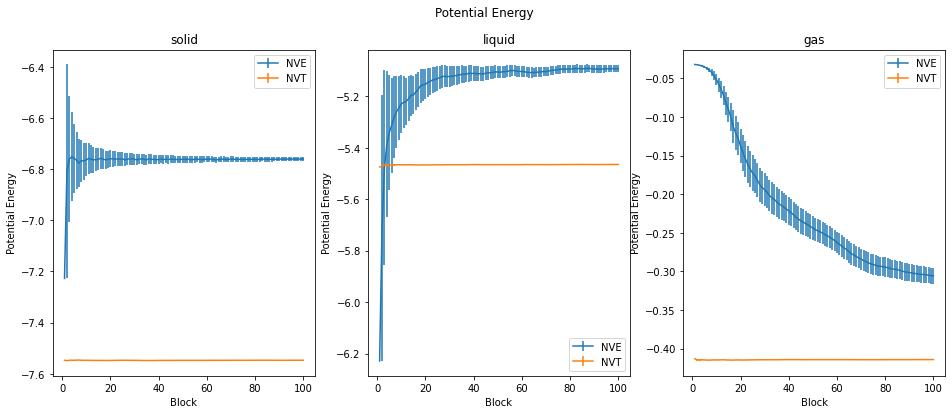

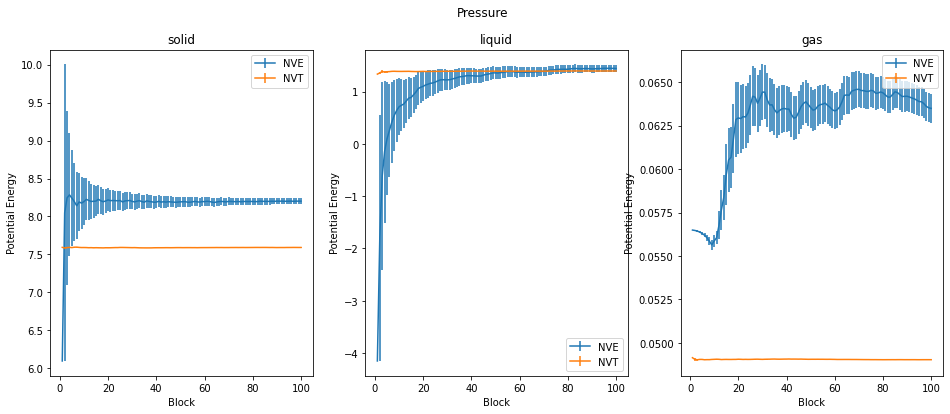

In [36]:
fig, ax = plt.subplots(1,3,figsize=(16,6))
plt.suptitle("Potential Energy")
for i1, p in enumerate(phases):
    i, pot, err = np.loadtxt(f"../es4/4.3/outputs/{p}/ave_epot.dat", unpack=True)
    ax[i1].set_title(p)
    ax[i1].errorbar(i, pot, yerr=err, label="NVE")
    
    i, _, pot, err = np.loadtxt(f"outputs/{p}/ave_epot.dat", unpack=True)
    ax[i1].errorbar(i, pot, yerr=err, label="NVT")
    ax[i1].legend()
    ax[i1].set_xlabel("Block")
    ax[i1].set_ylabel("Potential Energy")
plt.show()

fig, ax = plt.subplots(1,3,figsize=(16,6))
plt.suptitle("Pressure")
for i1, p in enumerate(phases):
    i, pot, err = np.loadtxt(f"../es4/4.3/outputs/{p}/ave_pres.dat", unpack=True)
    ax[i1].set_title(p)
    ax[i1].errorbar(i, pot, yerr=err, label="NVE")
    
    i, _, pot, err = np.loadtxt(f"outputs/{p}/ave_pres.dat", unpack=True)
    ax[i1].errorbar(i, pot, yerr=err, label="NVT")
    ax[i1].legend()
    ax[i1].set_xlabel("Block")
    ax[i1].set_ylabel("Potential Energy")
plt.show()

## <span style="color:green"> Results </span>
I did not manage to compare the NVT (Metropolis) and NVE (Verlet) ensembles, as the graphs show. What I would expect, however, is that the two methods would produce a potential energy of the same order of magnitude. This expectation is not met by the following graphs, and I think that the true risult is hidden by the fact that the error bars are way too big for smaller blocks, compared to teh NVE ensemble, therefore not comparing the results correctly. The reason for these huge error bars could be, for example, that the system has not been correctly equilibrated, and that the datablocking method is called while the system is still performing equilibration moves.